In [1]:
import sys
sys.path.append('/home/socolovsky_lab/ccount/ccount/workflow/scripts')
from ccount.blob.io import load_locs, save_crops, load_crops
from ccount.blob.misc import crops_stat
from ccount.clas.pca_tsne import pca_tsne


from ccount.img.read_czi import read_czi, parse_image_arrays
from ccount.blob.crop_blobs import crop_blobs
from ccount.blob.plot import plot_flat_crop, plot_flat_crops, pop_label_flat_crops, show_rand_crops

import numpy as np
import pandas as pd
import subprocess

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# show file names of all blobs that needs to be labeled
%ls ../../res/blob_locs/
%ls ../../res/classification1/pos/

250K_NoEpo_1.0.locs.npy.gz*
250K_NoEpo_1.1.locs.npy.gz*
250K_NoEpo_1.2.locs.npy.gz*
250K_NoEpo_1.3.locs.npy.gz*
250K_point5Epo_1.0.locs.npy.gz*
250K_point5Epo_1.1.locs.npy.gz*
250K_point5Epo_1.2.locs.npy.gz*
250K_point5Epo_1.3.locs.npy.gz*
IL17AF_NO_EPO_1_FIRST_SCAN-Stitching-01.0.locs.npy.gz*
IL17AF_NO_EPO_1_FIRST_SCAN-Stitching-01.1.locs.npy.gz*
IL17AF_NO_EPO_1_FIRST_SCAN-Stitching-01.2.locs.npy.gz*
IL17AF_NO_EPO_1_FIRST_SCAN-Stitching-01.3.locs.npy.gz*
IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.0.locs.npy.gz*
IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.1.locs.npy.gz*
IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.2.locs.npy.gz*
IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.3.locs.npy.gz*
vis_blob_detection/
250K_NoEpo_1.0.crops.clas.npy.gz*
250K_NoEpo_1.1.crops.clas.npy.gz*
250K_NoEpo_1.2.crops.clas.npy.gz*
250K_NoEpo_1.3.crops.clas.npy.gz*
250K_point5Epo_1.0.crops.clas.npy.gz*
250K_point5Epo_1.1.crops.clas.npy.gz*
250K_point5Epo_1.2.crops.clas.npy.gz*
250K_point5Epo_1.3.crops.clas.npy.

# User Parameters

In [3]:
# pos/clas.npy.gz, blob_crops/crops.npy.gz, or blob_locs/locs.npy.gz
loc_file = '../../res/classification1/pos/IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.0.crops.clas.npy.gz'  

image_index = 0  # 0 if loc_file = 'xxx.0.locs.npy.gz'

# corresponding czi file (must match loc_file)
czi_file = '../../data/IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.czi'  

## output file name, please don't over-write important files!!!
out_name = '../../res/labeled/IL17AF_POINT1_EPO_1_FIRST_SCAN.0.labeled.npy.gz' # file name to be saved in, will over-write existing files

# Read Data

In [4]:
locs = load_crops(loc_file)  # contains x,y,z in the first 3 columns

czi = read_czi(czi_file)  # image array of 4 scanned areas
image = parse_image_arrays(czi, i=image_index)  # one of the scanned areas
czi=[] # release RAM
# np.save("image.npy", image)  # save temp file for quick reload
# image = np.load('image.npy')

Reading ../../res/classification1/pos/IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.0.crops.clas.npy.gz
n-crop: 4, crop width: 80
4 Yes, 0 No, 0 Uncertain, 0 Unlabeled
Total: 4
read_czi: ../../data/IL17AF_POINT1_EPO_1_FIRST_SCAN-Stitching-07.czi
(4, 1, 70819, 65875, 1)


# View Data

showing blob 3


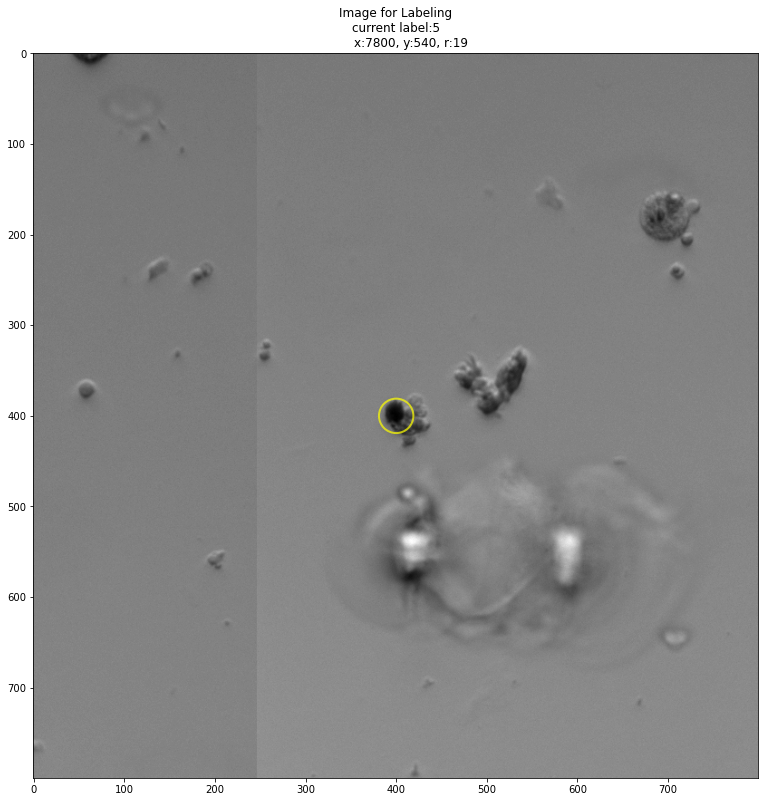

In [5]:
i = np.random.choice(len(locs))
print('showing blob {}'.format(i))

crops = crop_blobs(locs[i:i+1], image, crop_width=400)  # User can change crop_width
p = plot_flat_crop(crops[0, :],  image_scale=1)

## Labeling

In [6]:
crops = crop_blobs(locs, image, crop_width=400)
crops = pop_label_flat_crops(crops, random = True, seed = 1, skip_labels = [0, 1])

## Save

In [7]:
# decide output name and save
locs[:, 3] = crops[:, 3]
s = input ("would you like to save/over-write {} ? (y/n)".format(out_name))
if s == 'y':
    save_crops(locs, out_name)
else:
    print('exit without saving')

would you like to save/over-write ../../res/labeled/IL17AF_POINT1_EPO_1_FIRST_SCAN.0.labeled.npy.gz ? (y/n)y
Saving ../../res/labeled/IL17AF_POINT1_EPO_1_FIRST_SCAN.0.labeled.npy.gz
0 Yes, 4 No, 0 Uncertain, 0 Unlabeled
Total: 4
crops dim: (4, 25606)
crop width: 80


# Review Labeled DB (Optional)

In [18]:
labeled = load_crops(out_name)

Reading ../../res/labeled/IL17AF_POINT1_EPO_1_FIRST_SCAN.0.labeled.npy.gz
n-crop: 4, crop width: 80
0 Yes, 4 No, 0 Uncertain, 0 Unlabeled
Total: 4


In [19]:
## labeled as YES
_ = show_rand_crops(crops=labeled, label_filter=1, num_shown=3)

num_blobs after filtering is 0


Samples of 3 blobs will be plotted


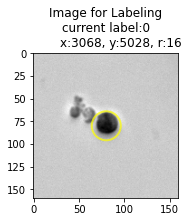

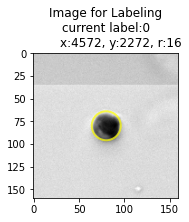

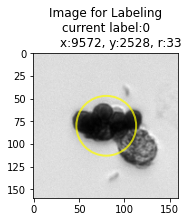

In [20]:
## labeled as NO
_ = show_rand_crops(crops=labeled, label_filter=0, num_shown=3)

Samples of 3 blobs will be plotted


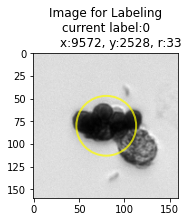

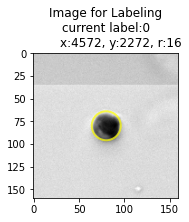

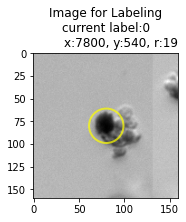

In [11]:
# any label (Optional)
_ = show_rand_crops(crops=labeled, label_filter='na', num_shown=3)

## Unsupervised classification (overview of blobs) (Optional)

In [21]:
crops_stat(crops)


0 Yes, 4 No, 0 Uncertain, 0 Unlabeled
Total: 4


dim before PCA (4, 640006)
dim after PCA (4, 4)
explained variance ratio: 0.9999999999999999
matched cluster_info: (4,)
unmatched data will be excluded from the plot
all labels: ['0']


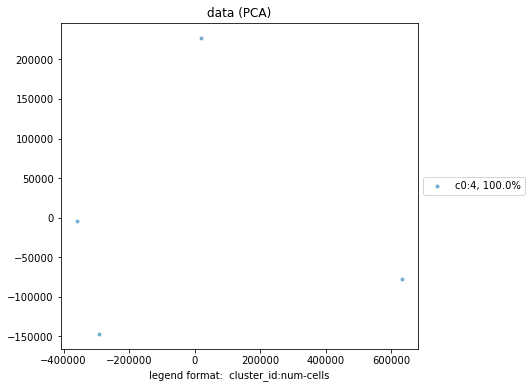

took 2.2 seconds



In [22]:
cluster_info = pd.DataFrame(crops[:, 3], columns=['cluster_id'])
tsne_df = pca_tsne(pd.DataFrame(crops), cluster_info=cluster_info)